In [1]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.regression.linear_model import yule_walker
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import AutoReg
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import pandas as pd
from pandas import DataFrame
from pandas import concat
from pandas.plotting import lag_plot
import numpy as np
import scipy.stats
import pylab
from sklearn.metrics import mean_squared_error

import yfinance as yf
from math import sqrt

%matplotlib inline

In [2]:
def parser(x):
    return datetime.datetime.strptime(x,'%Y-%m-%d')

In [3]:
# Get the data for the stock AAPL
start = '2012-01-01'
end = '2022-10-28'
ticker_symbol = 'SPY'

stock_data = yf.download(ticker_symbol, start, end)

[*********************100%***********************]  1 of 1 completed


In [4]:
stock_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-03,127.760002,128.380005,127.430000,127.500000,104.071884,193697900
2012-01-04,127.199997,127.809998,126.709999,127.699997,104.235168,127186500
2012-01-05,127.010002,128.229996,126.430000,128.039993,104.512672,173895000
2012-01-06,128.199997,128.220001,127.290001,127.709999,104.243301,148050000
2012-01-09,128.000000,128.179993,127.410004,128.020004,104.496361,99530200
...,...,...,...,...,...,...
2022-10-21,365.119995,374.799988,363.540009,374.290009,374.290009,130897700
2022-10-24,375.890015,380.059998,373.109985,378.869995,378.869995,85436900
2022-10-25,378.790009,385.250000,378.670013,384.920013,384.920013,78846300


In [5]:
stock_price = stock_data['Close']

In [6]:
#check for NA data
stock_price.isna().sum()

0

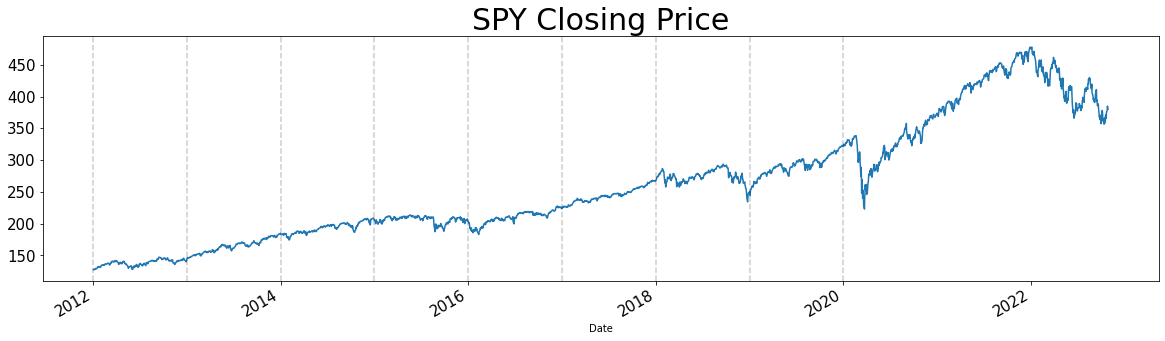

In [7]:
stock_price.plot(figsize = (20,5), fontsize = 15)
plt.title("%s Closing Price"%ticker_symbol, fontsize = 30)

for year in range(2012, 2021):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

plt.show()

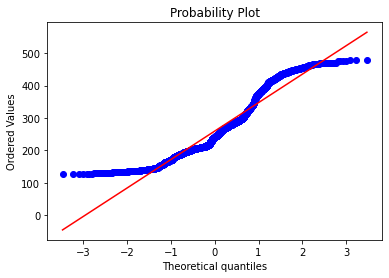

In [8]:
#plot QQ plot
scipy.stats.probplot(stock_price, plot = pylab)
pylab.show()

In [9]:
#As the plot shows that there are more data points at 100, this is not a normally distributed as it is expected from a
#time series data. Normally distributed data should follow the the redline. Theoretical quantiles means how many standard
#deviation away from the mean a data point is located.

In [10]:
stock_price.describe()

count    2724.000000
mean      259.606428
std        90.815752
min       127.500000
25%       194.759998
50%       240.529999
75%       307.062492
max       477.709991
Name: Close, dtype: float64

In [11]:
#check for stationarity
# ADF Test before differencing
adf = adfuller(stock_price,12)
print("\nStatistics analysis\n")
print("Statistic Test : " , adf[0])
print("p-value : " , adf[1])
print("# n_lags : " , adf[2])
print("No of observation: " , adf[3])
for key,value in adf[4].items():
    print(f" critical value {key} : {value}")


Statistics analysis

Statistic Test :  -0.9280804877164552
p-value :  0.7785845325111993
# n_lags :  11
No of observation:  2712
 critical value 1% : -3.43276353256931
 critical value 5% : -2.8626063225123146
 critical value 10% : -2.5673376385571394


In [12]:
#statistics test value is greater than the critical values and p value is higher than .05
#this is not a stationary data

In [13]:
#take first difference
data = stock_price.diff()
data = data.drop(data.index[0])

#check for stationarity
# ADF Test before differencing
adf = adfuller(data,12)
print("\nStatistics analysis\n")
print("Statistic Test : " , adf[0])
print("p-value : " , adf[1])
print("# n_lags : " , adf[2])
print("No of observation: " , adf[3])
for key,value in adf[4].items():
    print(f" critical value {key} : {value}")


Statistics analysis

Statistic Test :  -14.697521067369882
p-value :  2.9821595003252883e-27
# n_lags :  12
No of observation:  2710
 critical value 1% : -3.432765315465621
 critical value 5% : -2.8626071098943244
 critical value 10% : -2.5673380577606513


In [14]:
#statistics test value is lower than the critical values and p value is lower than .05
#this is a stationary data

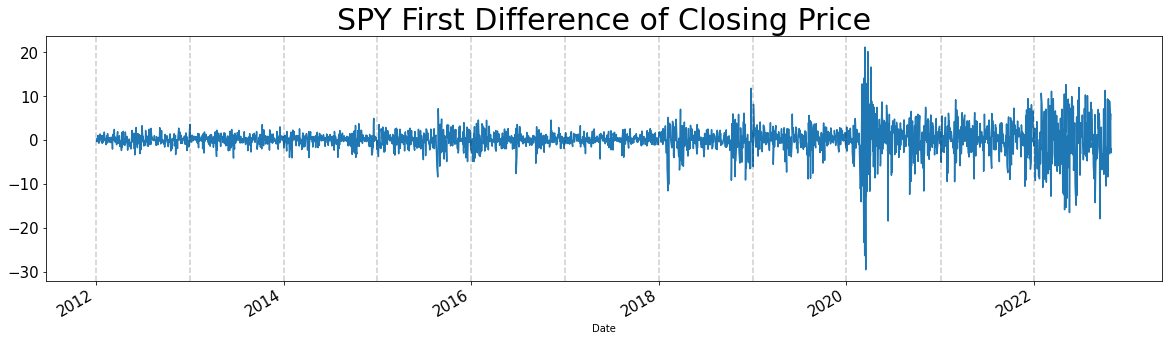

In [15]:
data.plot(figsize = (20,5), fontsize = 15)
plt.title("%s First Difference of Closing Price"%ticker_symbol, fontsize = 30)

for year in range(2012, 2023):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

plt.show()

In [16]:
#since difference data is stationary we can plot ACF and PACF

C:\Users\abhui\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


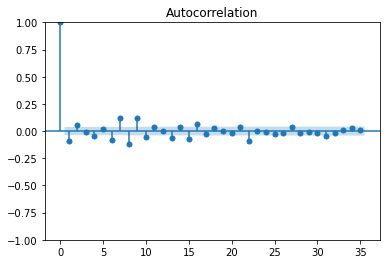

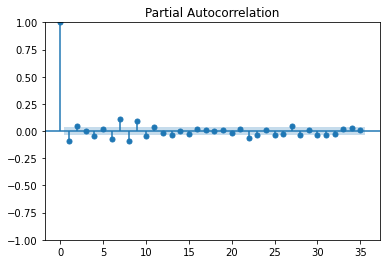

In [17]:
plot_acf(data);
plot_pacf(data);

In [18]:
#split test and train data
train_data = data[data.index < pd.to_datetime("2022-10-01", format='%Y-%m-%d')]
test_data = data[data.index > pd.to_datetime("2022-10-01", format='%Y-%m-%d')]

In [19]:
train_data

Date
2012-01-04    0.199997
2012-01-05    0.339996
2012-01-06   -0.329994
2012-01-09    0.310005
2012-01-10    1.110001
                ...   
2022-09-26   -3.640015
2022-09-27   -0.929993
2022-09-28    7.149994
2022-09-29   -7.739990
2022-09-30   -5.610016
Name: Close, Length: 2704, dtype: float64

In [20]:
test_data.tail()

Date
2022-10-21    8.880005
2022-10-24    4.579987
2022-10-25    6.050018
2022-10-26   -2.900024
2022-10-27   -2.039978
Name: Close, dtype: float64

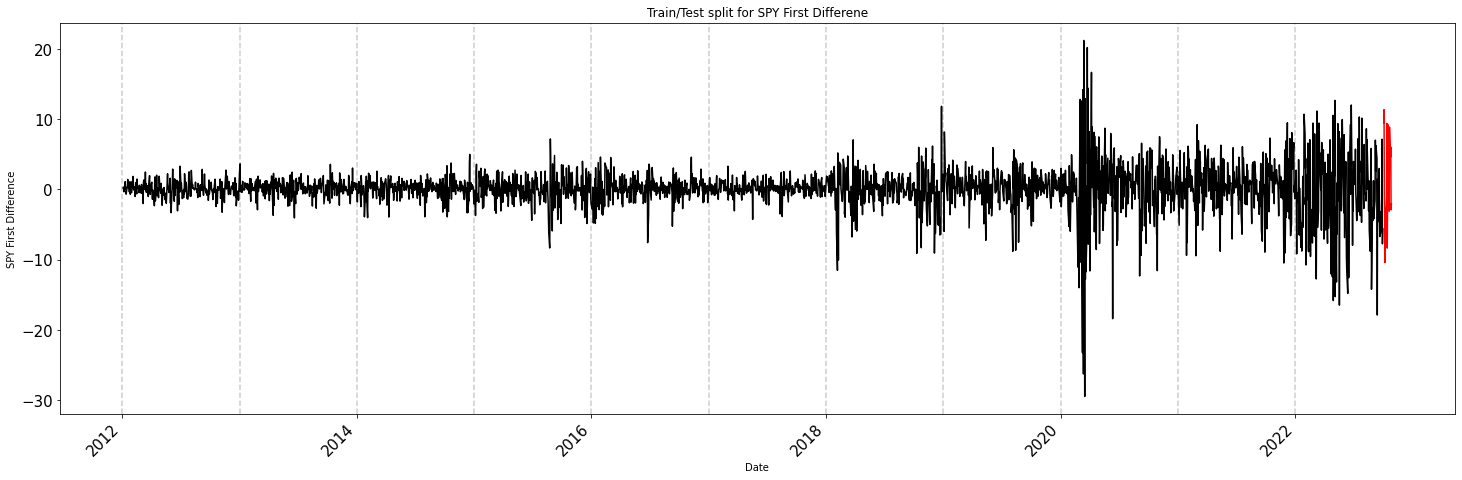

In [21]:
#plot the data
train_data.plot(figsize = (25,8), color = "black", fontsize = 15)
test_data.plot(figsize = (25,8), color = "red", fontsize = 15)
plt.ylabel('SPY First Difference')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for SPY First Differene")
for year in range(2012, 2023):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
plt.show()

In [46]:
# split dataset
X = data.values
train, test = X[:len(X)-6], X[len(X)-5:]

In [48]:
test

array([ 8.88000488,  4.57998657,  6.05001831, -2.90002441, -2.03997803])

In [47]:
train

array([ 0.19999695,  0.33999634, -0.3299942 , ...,  9.19000244,
        4.30999756, -2.63000488])

In [49]:
# train autoregression
model = AutoReg(train, lags=5)
model_fit = model.fit()
coef = model_fit.params
print('Coefficients: %s' % model_fit.params)

Coefficients: [ 0.09478406 -0.08914585  0.0542304  -0.00445488 -0.04937838  0.01662887]


In [50]:
# make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

In [51]:
#print predictions
for i in range(len(predictions)):
	print('predicted=%f, expected=%f' % (predictions[i], test[i]))

predicted=1.090324, expected=8.880005
predicted=-0.756713, expected=4.579987
predicted=0.173086, expected=6.050018
predicted=0.234996, expected=-2.900024
predicted=-0.010980, expected=-2.039978


In [52]:
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 5.247


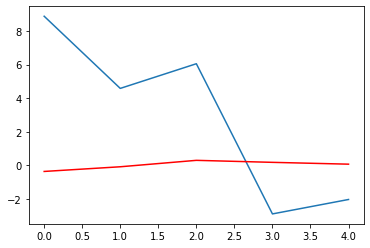

In [27]:
# plot results
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

In [28]:
import pmdarima as pm
from pmdarima import model_selection

In [29]:
# Fit a simple auto_arima model 
model = pm.auto_arima(train, start_p=1, start_q=1, start_P=1, start_Q=1,
                     max_p=5, max_q=5, max_P=5, max_Q=5, seasonal=False, m=0,
                     d=None, D=1, max_D=10, 
                     trace=True, stepwise=True, suppress_warnings=True, error_action='ignore')

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=13878.432, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=13902.992, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=13881.123, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=13883.493, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=13877.866, Time=0.15 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=13875.866, Time=0.08 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=13877.865, Time=0.14 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=13878.473, Time=0.76 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=13875.536, Time=0.16 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=13880.536, Time=0.12 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=13877.535, Time=0.26 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=13877.536, Time=0.26 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=13877.936, Time=0.30 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=13877.896, Time=1.30 sec

Best model:  ARIMA

In [30]:
# To print the summary 
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2718
Model:               SARIMAX(2, 0, 0)   Log Likelihood               -6933.768
Date:                Wed, 09 Nov 2022   AIC                          13875.536
Time:                        13:23:51   BIC                          13899.167
Sample:                             0   HQIC                         13884.079
                               - 2718                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0909      0.064      1.425      0.154      -0.034       0.216
ar.L1         -0.0896      0.008    -10.732      0.000      -0.106      -0.073
ar.L2          0.0507      0.008      6.586      0.000       0.036       0.066
sigma2         9.6236      0.108     89.349      0.000       9.412       9.835
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             14115.12
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):              14.01   Skew:                            -0.94
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [31]:
# Create predictions for the future, evaluate on test
prediction, coef_int = model.predict(n_periods=test.shape[0], return_conf_int=True)

# Print the error:
print("Test RMSE: %.3f" % np.sqrt(mean_squared_error(test, prediction)))

Test RMSE: 5.389


In [32]:
plt.plot(x_axis[:train.shape[0]], train, alpha=0.75)
plt.plot(x_axis[train.shape[0]:], prediction, alpha=0.75)  # Forecasts
plt.scatter(x_axis[train.shape[0]:],test,alpha=0.4, marker='x')  # Test data
plt.fill_between(x_axis[-prediction.shape[0]:],coef_int[:, 0], coef_int[:, 1], alpha=0.1, color='b')
plt.title("Forecasts vs. Train Data")

NameError: name 'x_axis' is not defined